In [21]:
"""
XGBoost multiclassifier for roof materials in D.C.
"""

import os, sys, glob, time
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import rasterio as rio

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score

import xgboost as xgb

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

print("Imports successful!")

Imports successful!


In [12]:
# Functions!

def compute_band_stats(geom, band, stat, nodataval):
    """
    Computes band statistics for given geometries

    Args:
        geom: geometries from which to sample image data
        band: the band to calculate statistics
        stat: which statostoic to be used (inherited)
        nodataval: the No Data value to be used
        
    """

    # Check the geometry type to determine which method to use
    if (geom.geometry.geom_type).isin(['Polygon', 'MultiPolygon']):
    
        stats = zonal_stats(
            self.geometries,
            self.img,
            stats=[stat],
            band_num=band,
            all_touched=True,
            nodata=nodataval,
            geojson_out=False
        )
        
        return {band: [feature['properties'][stat] for feature in stats]}

    else:

        coord_list = [(x, y) for x, y in zip(geom["geometry"].x, geom["geometry"].y)]
        
        points[f"{band}"] = [x for x in img.sample(coord_list, indexes=i+1)]
        
        points_df = points.reset_index()
        
        points_df[desc] = points_df[band_names].astype(np.float32)
        
        return points_df
        
        
def sample_image_da(img_path, geom, stat='mean'):
    """
    """
    # Sample the image at each geometry    
    # Create a copy of the polygons to store the results
    stats_df = geom.copy()

    # Number of bands to be processed
    n_bands = img.count
    band_names = img.long_name
    nodataval = img.nodata

    # Calculate the number of cores to use, reserving 2 cores
    num_cores = os.cpu_count()
    if num_cores is not None:  # os.cpu_count() can return None
        max_workers = max(1, num_cores - 1)  # Reserve 2 cores, but ensure at least 1 worker
    else:
        max_workers = 1  # Default to 1 worker if os.cpu_count() is None

    # Set up parallel processing
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for band, band_name in zip(n_bands, band_names):
            print(f"Processing for {band}.")
            futures.append(executor.submit(compute_band_stats, band, img_path, geom, stat, nodataval))

        for future in futures:
            result = future.result()
            band = list(result.keys())[0]
            stats_df[f'band_{band}'] = result[band]

    # Optionally, rename columns based on band names
    band_name_mapping = {f'band_{i + 1}': name for i, name in enumerate(band_names)}
    stats_df.rename(columns=band_name_mapping, inplace=True)

    return stats_df

    
def print_raster(raster, open_file):
    """
    :param raster: input raster file
    :param open_file: should the file be opened or not
    :return: print statement with raster information
    """
    if open_file is True:
        img = rxr.open_rasterio(raster,masked=True, cache=False).squeeze()
    else:
        img = raster
    print(
        f"shape: {img.rio.shape}\n"
        f"resolution: {img.rio.resolution()}\n"
        f"bounds: {img.rio.bounds()}\n"
        f"sum: {img.sum().item()}\n"
        f"CRS: {img.rio.crs}\n"
        f"NoData: {img.rio.nodata}"
        f"Array: {img}"
    )
    del img


# Apply a minimum distance sample to training data
def min_dist_sample(gdf, min_distance):
    """
    Filters the GeoDataFrame to ensure samples are at least min_distance apart.

    Args:
        gdf: GeoDataFrame containing 'geometry' column.
        min_distance: Minimum distance between samples in the same units as the geometry.

    Returns:
        Filtered GeoDataFrame.
    """
    coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf.geometry])
    tree = KDTree(coords)
    indices_to_keep = set(range(len(gdf)))

    for i in range(len(gdf)):
        if i not in indices_to_keep:
            continue
        indices = tree.query_radius([coords[i]], r=min_distance)[0]
        for index in indices:
            if index != i:
                indices_to_keep.discard(index)

    del coords, tree, indices

    return gdf.iloc[list(indices_to_keep)]
    

In [22]:
# Load our image data to check on the format
stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_data_psscene15b.tif')
stack_da = rxr.open_rasterio(stack_da_fp, masked=True, cache=False).squeeze()
print_raster(stack_da, open_file=False)
band_names = stack_da.long_name
del stack_da

{'coastal_blue': 1, 'blue': 2, 'green_i': 3, 'green': 4, 'yellow': 5, 'red': 6, 'rededge': 7, 'nir': 8}


In [5]:
band_names = list(band_names)
band_names.append('class_code')
band_names.append('uid')
band_names

['coastal_blue',
 'blue',
 'green_i',
 'green',
 'yellow',
 'red',
 'rededge',
 'nir',
 'ndre',
 'vgnir',
 'vrnir',
 'ndbibg',
 'ndbirg',
 'mnf1',
 'mnf2',
 'class_code',
 'uid']

In [9]:
# # Load the training data (footprints)
# gdf_path = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
# ref = gpd.read_file(gdf_path)
# footprints.head()

In [6]:
# Load the training data (sampled building footprints)
######################################################

# Footprints (from "sample-stack.py")
ref_tbl_path_fp = os.path.join(maindir,'data/tabular/mod/dc_data/training/dc_data_reference_sampled_footprint.csv')
ref = pd.read_csv(ref_tbl_path_fp)

# Retain samples of band matches
ref = ref[band_names]

# Create a numeric class code
class_mapping = {label: idx for idx, label in enumerate(ref['class_code'].unique())}
ref['Y'] = ref['class_code'].map(class_mapping)

ref.head()

,coastal_blue,blue,green_i,green,yellow,red,rededge,nir,ndre,vgnir,vrnir,ndbibg,ndbirg,mnf1,mnf2,class_code,uid,Y
0,729.166667,759.000000,934.916667,1014.416667,1022.750000,991.916667,1354.000000,2831.000000,0.353279,-0.474585,-0.484421,-0.151010,-0.015807,34.201024,3.498035,CS,1CS,0
1,818.789474,880.473684,974.736842,1116.736842,1149.894737,1237.526316,1419.315789,2172.000000,0.212262,-0.323376,-0.277551,-0.120774,0.049535,33.685900,-12.008492,CS,2CS,0
2,711.851852,762.851852,898.851852,963.111111,963.518519,954.481481,1276.740741,2377.000000,0.300473,-0.423011,-0.426390,-0.115378,-0.004242,30.182572,-3.002380,CS,3CS,0
3,603.733333,602.866667,754.666667,839.866667,853.200000,901.600000,1156.133333,2241.666667,0.319839,-0.457769,-0.428967,-0.164557,0.036074,22.293095,0.273247,CS,4CS,0
4,654.111111,738.777778,919.111111,1016.111111,1026.222222,1026.777778,1394.111111,3073.333333,0.375843,-0.503538,-0.499402,-0.158252,0.004384,34.056800,8.416481,CS,5CS,0


In [7]:
print(ref['class_code'].value_counts())

class_code
ME    29651
CS    27687
SL    11080
UR     1018
WS      866
TL      617
SH      589
Name: count, dtype: int64


In [13]:
t0 = time.time()

# Set up the model data
y = ref['Y']
X = ref.drop(['class_code', 'uid', 'Y'], axis=1)

# Define dataframes to store results for this feature set
results = pd.DataFrame()  # to store the model performance metrics
feat_imps = pd.DataFrame()  # to store the feature importances
prob_preds = pd.DataFrame()  # for testing optimum cutoff

# Calculate class weights
class_counts = y.value_counts()
total_samples = len(y)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
print(f'Class weights: {class_weights}')

# Set up the stratified K-fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Loop the folds
fold_idx = 1
for train_index, test_index in skf.split(X, y):
    print(f'Fold: {fold_idx}')

    # Split into train/test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Map class weights to each sample in the training set
    sample_weights = y_train.map(class_weights).values
    # print(sample_weights)

    # Initialize the XGBoost classifier for multi-class classification
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y)),
        n_estimators=1001,
        learning_rate=0.01,
        max_depth=8,
        random_state=42
    )

    # Fit the model
    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

    # Store feature importance
    fold_imps = pd.DataFrame({
        'Fold': fold_idx,
        'Feature': X.columns,
        'Importance': xgb_model.feature_importances_
    })

    feat_imps = pd.concat([feat_imps, fold_imps], axis=0)

    # Predict on the test set
    y_pred = xgb_model.predict(X_test)

    # Retrieve the accuracy/performance metrics
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Store the metrics into the results data frame
    fold_results = pd.DataFrame({
        'Fold': [fold_idx],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1],
        'MCC': [mcc],
        'Accuracy': [accuracy]
    })
    results = pd.concat([results, fold_results], ignore_index=True)

    # Store the probability values for cutoff testing
    y_pred_proba = xgb_model.predict_proba(X_test)

    # Store probabilities and true labels
    fold_probs = pd.DataFrame({
        'TrueLabel': y_test,
        'PredictedProb': list(y_pred_proba),
        'Fold': fold_idx
    })
    prob_preds = pd.concat([prob_preds, fold_probs], ignore_index=True)

    fold_idx += 1

    del fold_probs, fold_results, fold_imps

    t1 = (time.time() - t0) / 60
    print(f"Total elapsed time for fold {fold_idx}: {t1:.2f} minutes.")
    print("\n~~~~~~~~~~\n")

t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

# # Append the feature set-specific results to the overall results dataframes
# all_results = pd.concat([all_results, results], ignore_index=True)
# all_feat_imps = pd.concat([all_feat_imps, feat_imps], ignore_index=True)
# all_prob_preds = pd.concat([all_prob_preds, prob_preds], ignore_index=True)

# del results, feat_imps, prob_preds

Class weights: {1: 2.4116555934032577, 0: 2.5827283562682846, 2: 6.453790613718412, 3: 70.24361493123772, 5: 82.57274826789839, 4: 115.89627228525121, 6: 121.40577249575551}
Fold: 1
Total elapsed time for fold 2: 8.66 minutes.

~~~~~~~~~~

Fold: 2
Total elapsed time for fold 3: 13.08 minutes.

~~~~~~~~~~

Fold: 3
Total elapsed time for fold 4: 17.50 minutes.

~~~~~~~~~~

Fold: 4
Total elapsed time for fold 5: 21.92 minutes.

~~~~~~~~~~

Fold: 5
Total elapsed time for fold 6: 26.35 minutes.

~~~~~~~~~~

Fold: 6
Total elapsed time for fold 7: 30.78 minutes.

~~~~~~~~~~

Fold: 7
Total elapsed time for fold 8: 35.26 minutes.

~~~~~~~~~~

Fold: 8
Total elapsed time for fold 9: 39.90 minutes.

~~~~~~~~~~

Fold: 9
Total elapsed time for fold 10: 43.99 minutes.

~~~~~~~~~~

Fold: 10
Total elapsed time for fold 11: 47.80 minutes.

~~~~~~~~~~

Total elapsed time: 47.80 minutes.


In [17]:
results.head()

,Fold,Precision,Recall,F1,MCC,Accuracy
0,1,0.674478,0.592644,0.623716,0.426589,0.592644
1,2,0.672311,0.593344,0.622755,0.426521,0.593344
2,3,0.670236,0.587470,0.616463,0.422069,0.587470
3,4,0.666519,0.589428,0.618698,0.419723,0.589428
4,5,0.675707,0.591386,0.621179,0.427572,0.591386


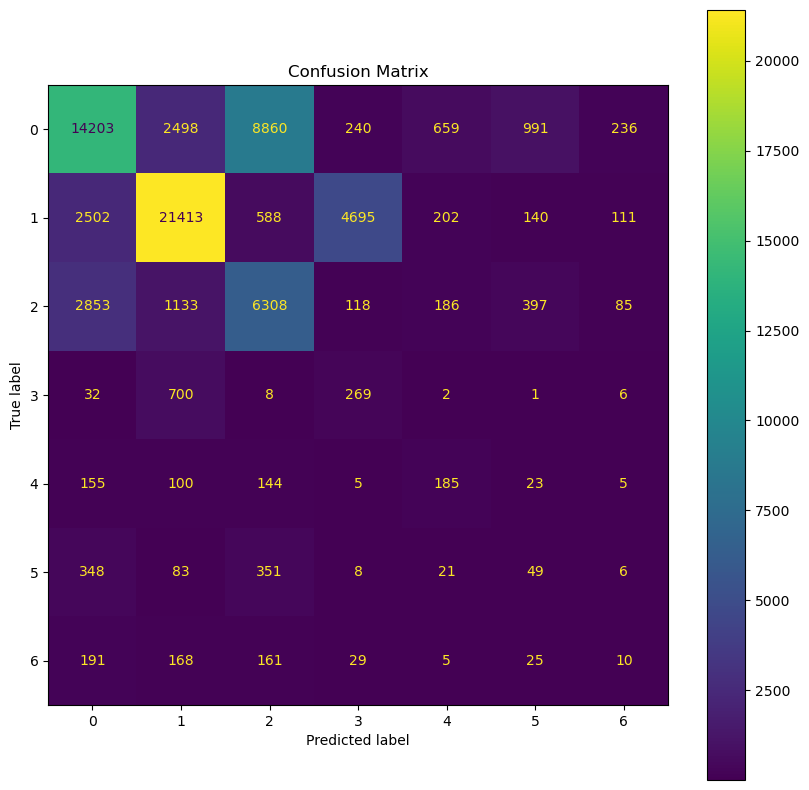

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Combine true labels and predicted labels across all folds
all_true_labels = []
all_pred_labels = []

for fold in range(1, fold_idx):
    fold_data = prob_preds[prob_preds['Fold'] == fold]
    all_true_labels.extend(fold_data['TrueLabel'])
    all_pred_labels.extend(np.argmax(np.vstack(fold_data['PredictedProb']), axis=1))

# Create the confusion matrix
cm = confusion_matrix(all_true_labels, all_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.title('Confusion Matrix')

plt.savefig(os.path.join(maindir,'figures/FigX_xgboost_confusion_matrix.png'), dpi=300, bbox_inches='tight')

plt.show()

In [19]:
from sklearn.metrics import classification_report

# Create a classification report and convert it to a DataFrame
cor_labels = [label for label, idx in sorted(class_mapping.items(), key=lambda item: item[1])]
cr_df = pd.DataFrame(classification_report(all_true_labels, all_pred_labels, target_names=cor_labels, output_dict=True)).transpose()

# Compute the average accuracy metrics across the 10 folds
average_metrics = cr_df.loc[cor_labels].mean()

# Display the DataFrame
cr_df

,precision,recall,f1-score,support
CS,0.700207,0.512984,0.592149,27687.000000
ME,0.820579,0.722168,0.768234,29651.000000
SL,0.384166,0.569314,0.458764,11080.000000
UR,0.050149,0.264244,0.084300,1018.000000
TL,0.146825,0.299838,0.197123,617.000000
WS,0.030135,0.056582,0.039326,866.000000
SH,0.021786,0.016978,0.019084,589.000000
accuracy,0.593458,0.593458,0.593458,0.593458
macro avg,0.307693,0.348873,0.308426,71508.000000
weighted avg,0.673417,0.593458,0.622442,71508.000000


In [15]:
# Save out the results
results.to_csv(os.path.join(maindir,'xgboost_folds_results.csv'))
feat_imps.to_csv(os.path.join(maindir,'xgboost_folds_feat_imps.csv'))
prob_preds.to_csv(os.path.join(maindir,'xgboost_folds_prob_peds.csv'))
cr_df.to_csv(os.path.join(maindir,'xgboost_classification_report_avg.csv'))